In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [16]:
add_key="_netzero"
innovations = CSV.File("./data-case-roadmap/innovations"*add_key*".csv",header=1,delim=",") |> DataFrame
#innovations = CSV.File("./data/innovations_append.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki"*add_key*".csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise"*add_key*".csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=168
#innovations[3,3]=2
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,90.68,1,5.48,7.62,3.34,5.05,1.1,0
2,2,77.52,3,9.94,2.38,7.94,3.82,5.44,0
3,3,98.51,2,4.44,1.21,5.09,6.52,8.67,0
4,4,121.59,3,4.44,1.21,5.09,6.52,8.67,0
5,5,122.1,1,4.6,1.34,2.04,0.12,8.86,0
6,6,122.26,2,5.48,7.62,3.34,5.05,1.1,0
7,7,89.63,1,5.48,7.62,3.34,5.05,1.1,0
8,8,85.84,1,4.6,1.34,2.04,0.12,8.86,0
9,9,121.08,3,8.32,8.84,0.65,9.9,9.65,0


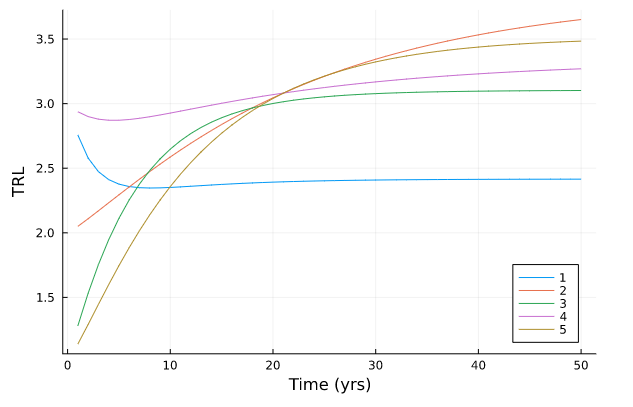

Choose Template for Innovation (1-5)LABS from PE
stdin> 3
Do you want to change initial TRL (Enter 0 if no)LABS from PE TRL:1
stdin> 0
Choose Template for Innovation (1-5)Pyrolysis of LDPE
stdin> 2
Do you want to change initial TRL (Enter 0 if no)Pyrolysis of LDPE TRL:2
stdin> 3
Choose Template for Innovation (1-5)Pyrolysis of HDPE
stdin> 2
Do you want to change initial TRL (Enter 0 if no)Pyrolysis of HDPE TRL:2
stdin> 0
Choose Template for Innovation (1-5)Pyrolysis of PP
stdin> 2
Do you want to change initial TRL (Enter 0 if no)Pyrolysis of PP TRL:2
stdin> 0
Choose Template for Innovation (1-5)Recycling back to PLA usin Clay
stdin> 1
Do you want to change initial TRL (Enter 0 if no)Recycling back to PLA usin Clay TRL:3
stdin> 2
Choose Template for Innovation (1-5)Alkaline hydrolysis of PLA
stdin> 4
Do you want to change initial TRL (Enter 0 if no)Alkaline hydrolysis of PLA TRL:3
stdin> 2
Choose Template for Innovation (1-5)Alcoholysis of PLA
stdin> 5
Do you want to change initial TRL 

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,100,1,4.44,1.21,5.09,6.52,8.67,0
2,2,100,3,8.32,8.84,0.65,9.9,9.65,0
3,3,100,2,8.32,8.84,0.65,9.9,9.65,0
4,4,100,2,8.32,8.84,0.65,9.9,9.65,0
5,5,100,2,4.6,1.34,2.04,0.12,8.86,0
6,6,100,2,5.48,7.62,3.34,5.05,1.1,0
7,7,100,1,9.94,2.38,7.94,3.82,5.44,0
8,8,100,3,5.48,7.62,3.34,5.05,1.1,0
9,9,100,3,4.6,1.34,2.04,0.12,8.86,0


In [17]:
innovations[!,:Cost_per_RL].=100

display("image/png", read("./data-case-roadmap/trl_profile_template.png"))
inn_template = CSV.File("./data/innovations.csv",header=1,delim=",") |> DataFrame
for i in 1:nrow(innovations)
    println("Choose Template for Innovation (1-5)", innovations[i,:name])
    temp_inn=readline()
    innovations[i,3:ncol(inn_template)]=inn_template[parse(Int64,temp_inn),3:ncol(inn_template)]
    println("Do you want to change initial TRL (Enter 0 if no)", innovations[i,:name]," TRL:",innovations[i,:RL])
    temp_rl=readline()
    if parse(Int64,temp_rl)>0
        innovations[i,:RL]=parse(Int64,temp_rl)
    end
end
innovations
#CSV.write("./data-case-roadmap/innovation-user.csv",innovations)

In [18]:
innovations[!,:Sojourn2]+=0.5*ones(nrow(innovations))
innovations[!,:Sojourn3]+=0.5*ones(nrow(innovations))

11-element Vector{Float64}:
 5.59
 1.15
 1.15
 1.15
 2.54
 3.84
 8.440000000000001
 3.84
 2.54
 2.54
 2.54

In [19]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    println(i," ",rl_t)
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

In [20]:
v=innovations[:,:name]
v1=reshape(v, 1,length(v))
v

11-element Vector{String31}:
 "LABS from PE"
 "Pyrolysis of LDPE"
 "Pyrolysis of HDPE"
 "Pyrolysis of PP"
 "Recycling back to PLA usin Clay"
 "Alkaline hydrolysis of PLA"
 "Alcoholysis of PLA"
 "Bio Ethanol"
 "MSW pyrolysis to small olefins"
 "Source Segregation"
 "AI robot segregation"

4 3.168878693109103
1 1.27557854367634
1 1.5189350659447554
1 1.7321155019997698
1 1.9177320538487306
1 2.0785953550016347
1 2.217499958137603
1 2.337102809291575
1 2.4398589679984126
1 2.5279928053327136
1 2.6034910860647584
1 2.668109274697372
1 2.723385475129336
1 2.770658377246308
1 2.8110868680801806
1 2.8456698188791085
1 2.8752651321408096
1 2.9006075176821344
1 2.922324724287364
1 2.94095212330762
1 2.956945649893463
1 2.9706931750848646
1 2.982524420875327
1 2.992719549844914
1 3.001516567531982
1 3.009117673965461
1 3.015694693909034
1 3.021393705587447
1 3.0263389764785584
1 3.030636303163039
1 3.034375840870216
1 3.037634497636035
1 3.0404779581164445
1 3.0429623931779317
1 3.0451359034391587
1 3.047039737936576
1 3.0487093229754043
1 3.0501751309315233
1 3.051463414208904
1 3.0525968256492173
1 3.053594943356128
1 3.054474715062578
1 3.0552508347675786
1 3.055936062338948
1 3.056541495066391
1 3.057076798708052
1 3.0575504043623347
1 3.057969676479841
1 3.0583410564774796


10 2.4196887108659055
10 2.419793369075321
10 2.4198866807303236
10 2.419969875678658
11 1.2465782674883554
11 1.4446207918907397
11 1.6028185888397852
11 1.729411691985434
11 1.8314269860115746
11 1.914454242903735
11 1.982788380798274
11 2.039673834430192
11 2.087545700059835
11 2.128232531860334
11 2.1631149022396134
11 2.193244639276391
11 2.2194325321073984
11 2.2423120451533096
11 2.2623853155004294
11 2.2800562971136773
11 2.295654678021459
11 2.309453211984385
11 2.321680361562106
11 2.3325296028047307
11 2.342166347661274
11 2.3507331593129344
11 2.358353736930959
11 2.3651360064251468
11 2.371174555460003
11 2.3765525820544418
11 2.3813434776931013
11 2.3856121318872976
11 2.3894160211970075
11 2.3928061288301308
11 2.3958277289550463
11 2.3985210613214276
11 2.4009219156542594
11 2.4030621408502664
11 2.404970090765117
11 2.406671015985083
11 2.4081874091847144
11 2.409539310311882
11 2.4107445767934834
11 2.411819123134721
11 2.412777133632511
11 2.4136312513966507
11 2.414

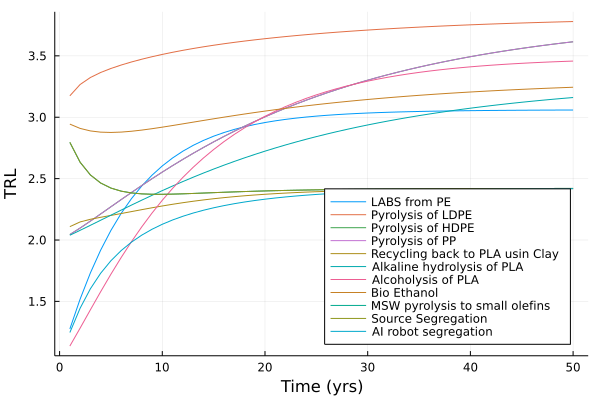

In [21]:
get_RL_atT(4,25)
pal = palette(:default)
plot_ref=plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=v1, legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig("./result-case-roadmap/evolution-inn_ctmc.svg")
plot_ref

In [22]:
### iam_model=DataFrame()
#zero is 2020 SSP2-34 IMAGE 3.0.1

#iam_model[!,"Yr"]=[0;10;20;30;40;50]
#iam_model[!,"Back_RedFr_Elec"]=[1
#0.949784976
#0.809145552
#0.623734704
#0.41470694
#0.331447018]

iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
iam_model


#CSV.write("./data/iam_model.csv",iam_model)

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [23]:
compromise

,k,i,GWP,Theta,Per_Recy,Per_Comp,GHG_ElecInd,GHG_Transport
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,8.5782,1.3565,0.297765,0.0,3.4143,0.8678
2,2,1,2.5118,0.3955,0.297765,0.0,1.2805,0.3335
3,3,1,2.9585,0.0,0.0,0.0,0.8363,0.0
4,4,1,2.6374,0.5189,0.297765,0.0,1.2794,0.3335
5,5,1,2.6374,0.5015,0.29772,0.0,1.2969,0.3382
6,6,1,2.6374,0.5189,0.297765,0.0,1.2794,0.3335
7,7,1,2.6374,0.4931,0.288225,0.0,1.2653,0.3228
8,8,1,2.9949,0.1134,0.026505,0.0,0.8753,0.0298
9,9,1,3.8684,1.2855,0.297585,0.0008,1.4822,0.3861


In [24]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

## Additional functions

In [25]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(9,50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

2.5803572856875885

In [26]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,100,1,4.44,1.71,5.59,6.52,8.67,0
2,2,100,3,8.32,9.34,1.15,9.9,9.65,0
3,3,100,2,8.32,9.34,1.15,9.9,9.65,0
4,4,100,2,8.32,9.34,1.15,9.9,9.65,0
5,5,100,2,4.6,1.84,2.54,0.12,8.86,0
6,6,100,2,5.48,8.12,3.84,5.05,1.1,0
7,7,100,1,9.94,2.88,8.44,3.82,5.44,0
8,8,100,3,5.48,8.12,3.84,5.05,1.1,0
9,9,100,3,4.6,1.84,2.54,0.12,8.86,0


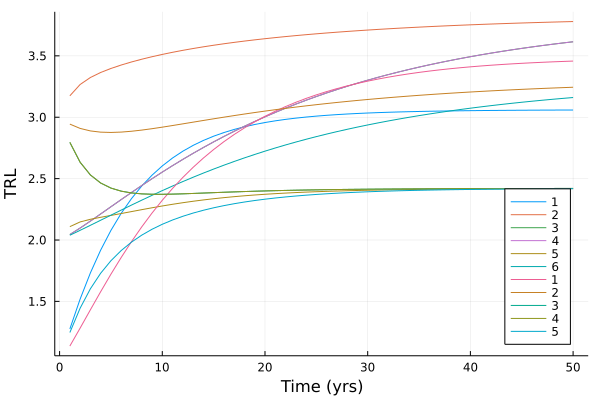

In [27]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=[1;2;3;4;5;6]', legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig(plot_ref,"evolution-inn_ctmc.svg")

In [29]:
d1=0.982

0.982

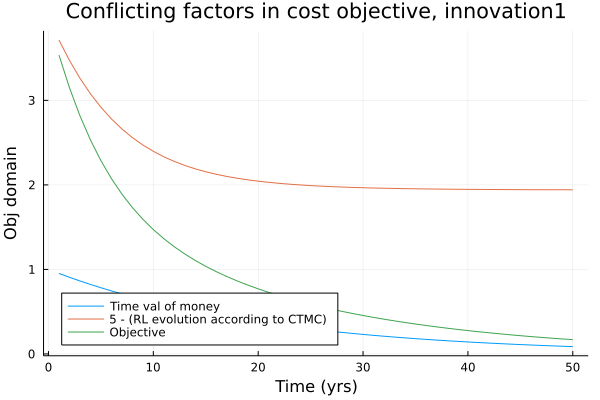

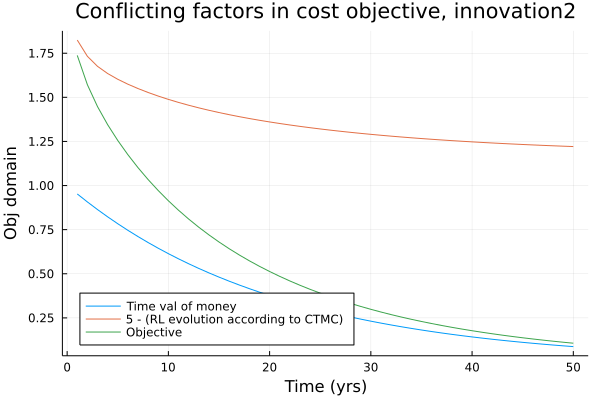

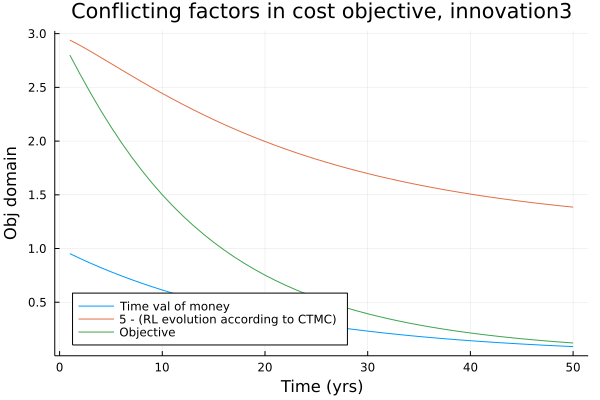

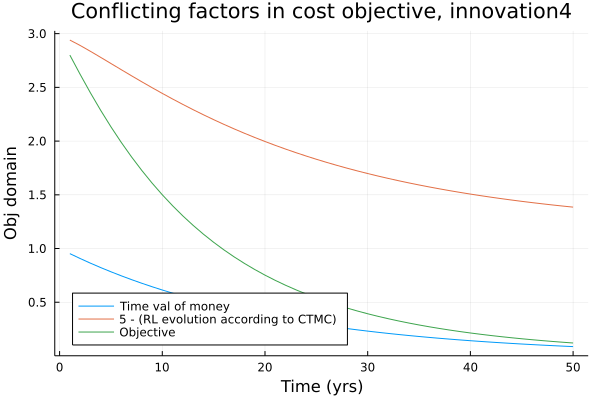

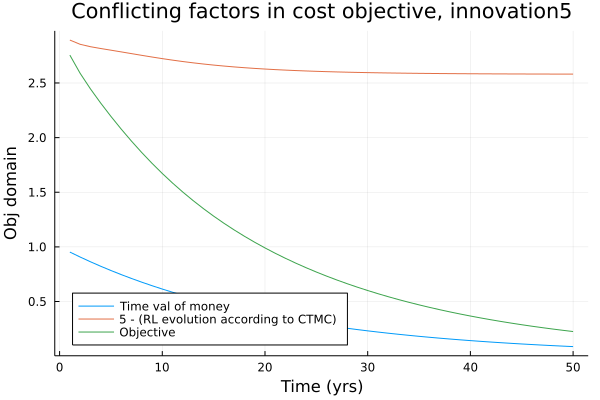

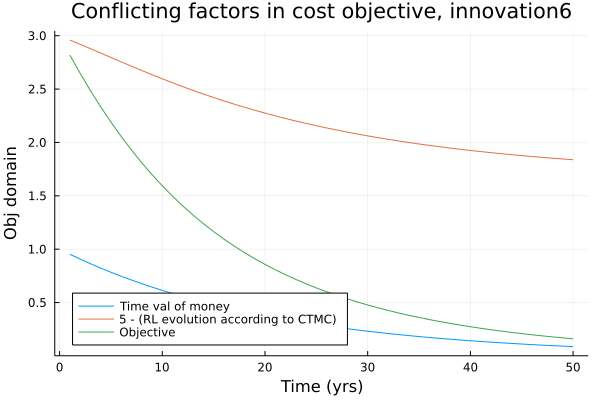

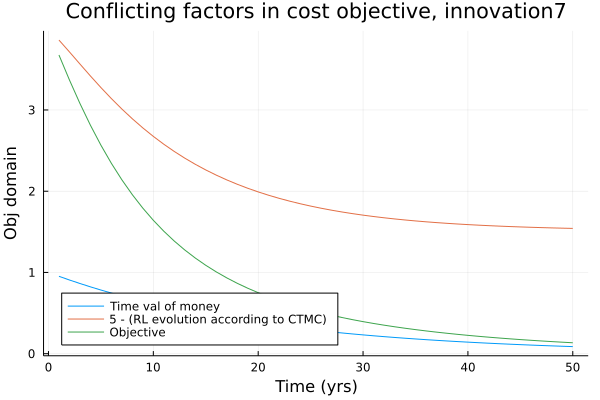

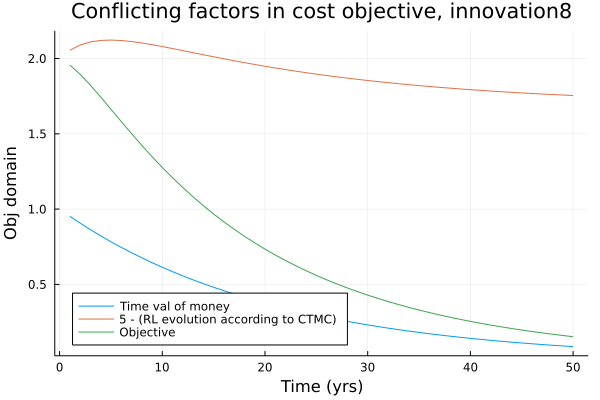

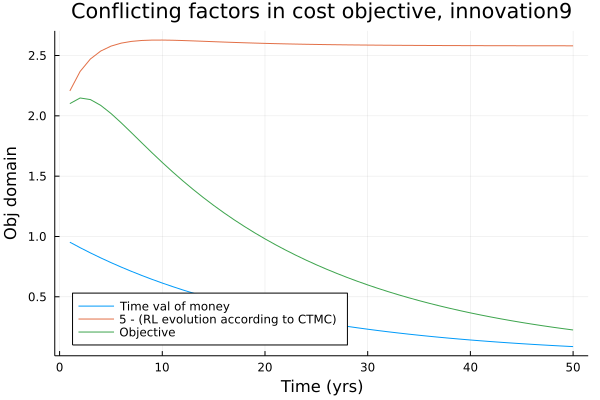

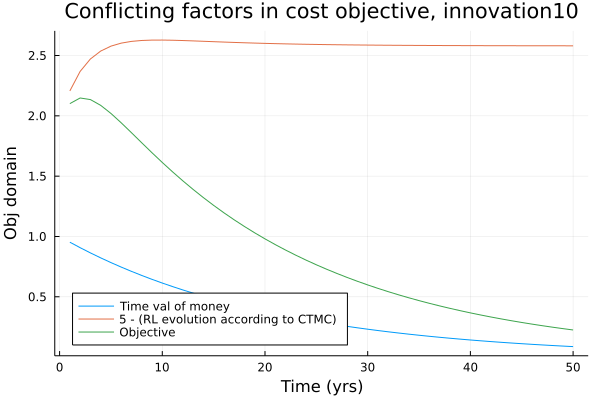

In [35]:
inn=1
for inn in 1:10
    plot(range(1, 50; length = 50),[1.05^(-1*i) for i = 1:50],labels="Time val of money")
    plot!(range(1, 50; length = 50), [get_latest.(inn,1:50)],labels="5 - (RL evolution according to CTMC)")
    plot_ref=plot!(range(1, 50; length = 50), [1.05^(-1*i)*get_latest.(inn,i) for i = 1:50], labels="Objective",legend=:bottomleft,
            xlab="Time (yrs)", ylab="Obj domain", title="Conflicting factors in cost objective, innovation"*string(inn))
#savefig(plot_ref,"evolution-inn_costObj.svg")
    display(plot_ref)
end

#0.986 instead of 0.968 _ NOT TRIED YET - TODO

In [36]:
intvls=40
fval=zeros(intvls+1,nrow(innovations))
tval=zeros(intvls+1,nrow(innovations))
for inn in 1:nrow(innovations)
    tval[:,inn]=[i*(50/intvls) for i = 0:intvls]
    fval[:,inn]=[1.05^(-1*i*(50/intvls))*get_latest.(inn,i*(50/intvls)) for i =0:intvls]
end
[tval[:,1] fval]

41×12 Matrix{Float64}:
  0.0   3.98488   1.99913   2.98165   …  2.00224   2.00224   3.99968
  1.25  3.43454   1.69011   2.75501      2.12049   2.12049   3.48087
  2.5   2.97795   1.50587   2.53436      2.1469    2.1469    3.07336
  3.75  2.6001    1.36922   2.32629      2.10116   2.10116   2.74818
  5.0   2.28711   1.25544   2.1327       2.01964   2.01964   2.48284
  6.25  2.02696   1.15586   1.95385   …  1.92179   1.92179   2.2612
  7.5   1.80958   1.06688   1.78932      1.81811   1.81811   2.07209
  8.75  1.62667   0.986595  1.63842      1.7143    1.7143    1.90782
 10.0   1.47155   0.913737  1.50031      1.61334   1.61334   1.76305
 11.25  1.33885   0.847361  1.3741       1.51674   1.51674   1.63399
 12.5   1.2243    0.786698  1.2589    …  1.42517   1.42517   1.51789
 13.75  1.1245    0.73111   1.15381      1.33882   1.33882   1.4127
 15.0   1.03678   0.680055  1.058        1.25765   1.25765   1.31685
  ⋮                                   ⋱            ⋮         
 36.25  0.332933  0.

In [37]:
CSV.write("./data-case-roadmap/cost_inn_obj.csv",  Tables.table([tval[:,1] fval]), writeheader=true)


"./data-case-roadmap/cost_inn_obj.csv"

In [42]:
Tables.table([tval[:,1] fval])

Tables.MatrixTable{Matrix{Float64}} with 41 rows, 12 columns, and schema:
 :Column1   Float64
 :Column2   Float64
 :Column3   Float64
 :Column4   Float64
 :Column5   Float64
 :Column6   Float64
 :Column7   Float64
 :Column8   Float64
 :Column9   Float64
 :Column10  Float64
 :Column11  Float64
 :Column12  Float64

In [113]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0999915  0.177499  0.0364628  0.443145  0.242902
 0.091867   0.163873  0.0357651  0.454619  0.253875
 0.0712257  0.127883  0.0339008  0.484184  0.282807
 0.0599454  0.10831   0.0328882  0.500308  0.298547
 0.0556414  0.10083   0.032489   0.506256  0.304783

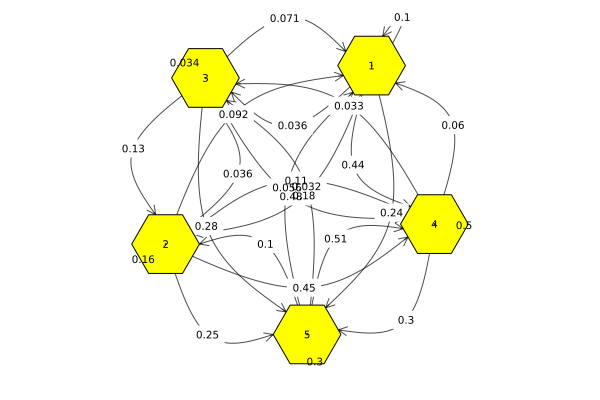

In [114]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)